In [1]:
!pip install tensorflow --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 4.7 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.19.0
    Uninstalling tensorboard-2.19.0:
      Successfully uninstalled tensorboard-2.19.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.19.0
    Uninstalling tensorflow-2.19.0:
      Successfully uninstalled tensorflow-2.19.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.
tensorflow-text 2.19.0 requires tensorflow<2.20,>=2.19.0, but you have tensorflow 2.20.0 which is incompatible.
tensorflow-decision-forests 1.12.0 requires tensorflow==2.19.0, but you have tensorflow 2.20.0 which is incompati

In [2]:
!pip install split-folders

# **Import Libraries**

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from tensorflow.keras.applications import VGG16

import splitfolders


# **Load The Dataset**

In [4]:
# Split Dataset into Train / Val / Test

INPUT_DIR = "/kaggle/input/human-face-emotions/data"   # change to your path
OUTPUT_DIR = "/kaggle/working/emotion_split"

splitfolders.ratio(
    INPUT_DIR,
    output=OUTPUT_DIR,
    seed=42,
    ratio=(0.7, 0.15, 0.15)
)

print("✅ Dataset split completed!")

Copying files: 265 files [00:02, 107.98 files/s]

✅ Dataset split completed!


In [5]:
# Define Paths & Load Classes

TRAIN_DIR = os.path.join(OUTPUT_DIR, "train")
VAL_DIR   = os.path.join(OUTPUT_DIR, "val")
TEST_DIR  = os.path.join(OUTPUT_DIR, "test")

emotion_classes = [
    d for d in os.listdir(TRAIN_DIR)
    if os.path.isdir(os.path.join(TRAIN_DIR, d))
]

print("Emotion Classes:", emotion_classes)


Emotion Classes: ['Happy', 'Angry', 'Sad']


# **Data Preprocessing**

In [6]:
# Data Generators (rescale = 1./255)

IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


In [7]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    shuffle=True,
    classes=emotion_classes,
    class_mode="sparse"
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    shuffle=False,
    classes=emotion_classes,
    class_mode="sparse"
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    shuffle=False,
    classes=emotion_classes,
    class_mode="sparse"
)


Found 184 images belonging to 3 classes.
Found 38 images belonging to 3 classes.
Found 42 images belonging to 3 classes.


In [8]:
class_names = list(train_generator.class_indices.keys())
NUM_CLASSES = train_generator.num_classes

print("Classes:", class_names)
print("Number of classes:", NUM_CLASSES)
print("Class indices:", train_generator.class_indices)


Classes: ['Happy', 'Angry', 'Sad']
Number of classes: 3
Class indices: {'Happy': 0, 'Angry': 1, 'Sad': 2}


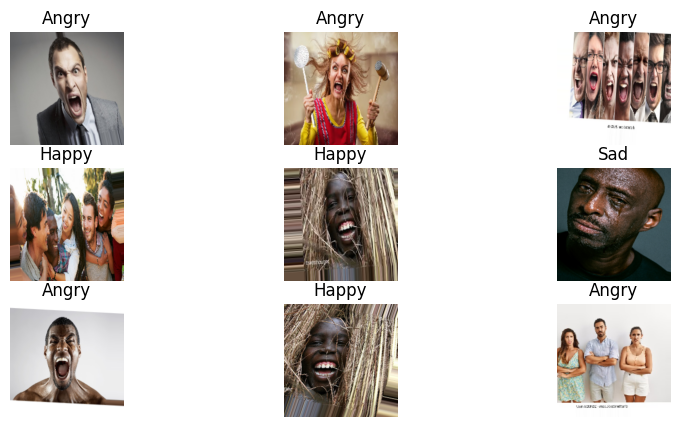

In [9]:
# Visualize Training Samples (RGB)

for images, labels in train_generator:
    plt.figure(figsize=(10, 5))
    for i in range(9):
        plt.subplot(3, 3, i + 1)

        img = images[i]
        plt.imshow(img)

        true_index = int(labels[i])
        true_label = class_names[true_index]

        plt.title(true_label)
        plt.axis("off")
    break

plt.show()


# **Model Building**

In [10]:
# model = Sequential([
#     Input(shape=(224, 224, 3)),   # ✅ 224 RGB input

#     Conv2D(32, (3,3), activation="relu"),
#     MaxPooling2D(2,2),

#     Conv2D(64, (3,3), activation="relu"),
#     MaxPooling2D(2,2),

#     Conv2D(128, (3,3), activation="relu"),
#     MaxPooling2D(2,2),

#     Conv2D(256, (3,3), activation="relu"),
#     MaxPooling2D(2,2),

#     Flatten(),

#     Dense(256, activation="relu"),
#     Dropout(0.5),

#     Dense(NUM_CLASSES, activation="softmax")
# ])

# model.compile(
#     optimizer="adam",
#     loss="sparse_categorical_crossentropy",
#     metrics=["accuracy"]
# )

# model.summary()

In [11]:
# Build VGG16 Model (rescale version)

base_model = VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze all VGG16 layers
# for layer in base_model.layers:
#     layer.trainable = False

base_model.trainable = False


I0000 00:00:1770369801.970635      24 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1770369801.973918      24 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
# from tensorflow.keras.layers import BatchNormalization

# x = base_model.output
# x = Flatten()(x)

# x = Dense(128, activation="relu")(x)
# x = BatchNormalization()(x)
# x = Dropout(0.5)(x)

# outputs = Dense(NUM_CLASSES, activation="softmax")(x)

# model = Model(inputs=base_model.input, outputs=outputs)

# model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
#     loss="sparse_categorical_crossentropy",
#     metrics=["accuracy"]
# )

# model.summary()


In [13]:
x = base_model.output
#x = Flatten()(x)
x = GlobalAveragePooling2D()(x)

x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)

outputs = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,846,787 (56.64 MB)

 Trainable params: 132,099 (516.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [14]:
# Train the Model

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
1/6 ━━━━━━━━━━━━━━━━━━━━ 1:24 17s/step - accuracy: 0.2812 - loss: 1.2491

I0000 00:00:1770369822.619925     107 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6/6 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step - accuracy: 0.2709 - loss: 1.2832 - val_accuracy: 0.4211 - val_loss: 1.1307
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 892ms/step - accuracy: 0.2878 - loss: 1.2110 - val_accuracy: 0.4211 - val_loss: 1.1045
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.3083 - loss: 1.2172 - val_accuracy: 0.4474 - val_loss: 1.0887
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.3659 - loss: 1.1830 - val_accuracy: 0.3947 - val_loss: 1.0812
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.4049 - loss: 1.1091 - val_accuracy: 0.3158 - val_loss: 1.0769
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.4019 - loss: 1.1124 - val_accuracy: 0.3158 - val_loss: 1.0722
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.3815 - loss: 1.1508 - val_accuracy: 0.3684 - val_loss: 1.0655
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 982ms/step - accuracy: 0.3882 - loss: 1.1747 - val_accuracy: 0.4211 - val_loss: 1.0601
Epoch 9/50
6/6 ━━━━━

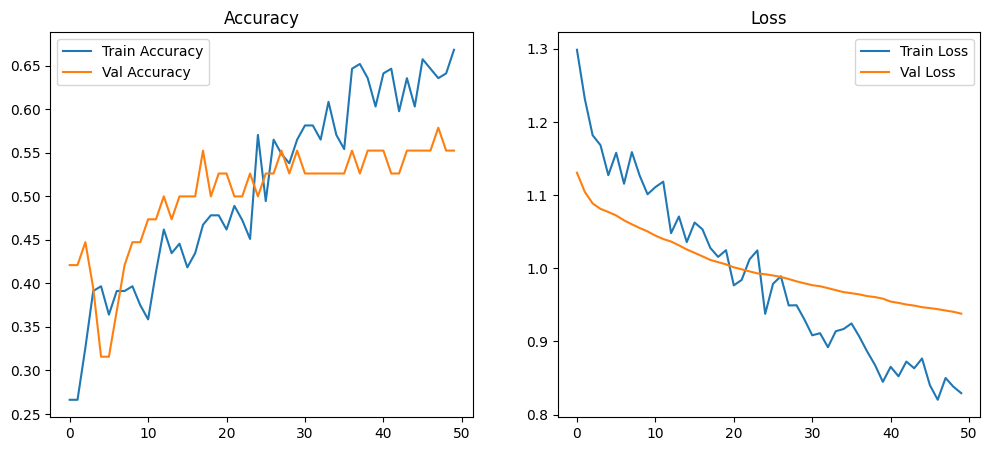

In [15]:
# Plot Accuracy & Loss

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(acc, label="Train Accuracy")
plt.plot(val_acc, label="Val Accuracy")
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(loss, label="Train Loss")
plt.plot(val_loss, label="Val Loss")
plt.title("Loss")
plt.legend()

plt.show()


# **Model Evaluation**

In [16]:
# Evaluate on Test Set

test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc*100:.2f}%")


2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 6s/step - accuracy: 0.6736 - loss: 0.9102
Test Accuracy: 66.67%


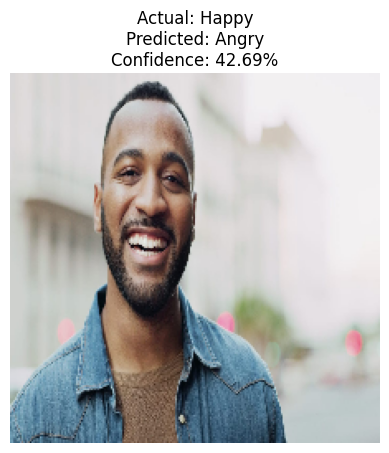

In [17]:
# Predict ONE Validation Image (Like Your Earlier Code)

for images, labels in val_generator:
    img = images[0]

    true_index = int(labels[0])
    true_label = class_names[true_index]

    preds = model.predict(np.expand_dims(img, axis=0), verbose=0)[0]
    pred_index = np.argmax(preds)
    pred_label = class_names[pred_index]
    confidence = preds[pred_index] * 100

    plt.imshow(img)
    plt.axis("off")
    plt.title(
        f"Actual: {true_label}\n"
        f"Predicted: {pred_label}\n"
        f"Confidence: {confidence:.2f}%"
    )
    break


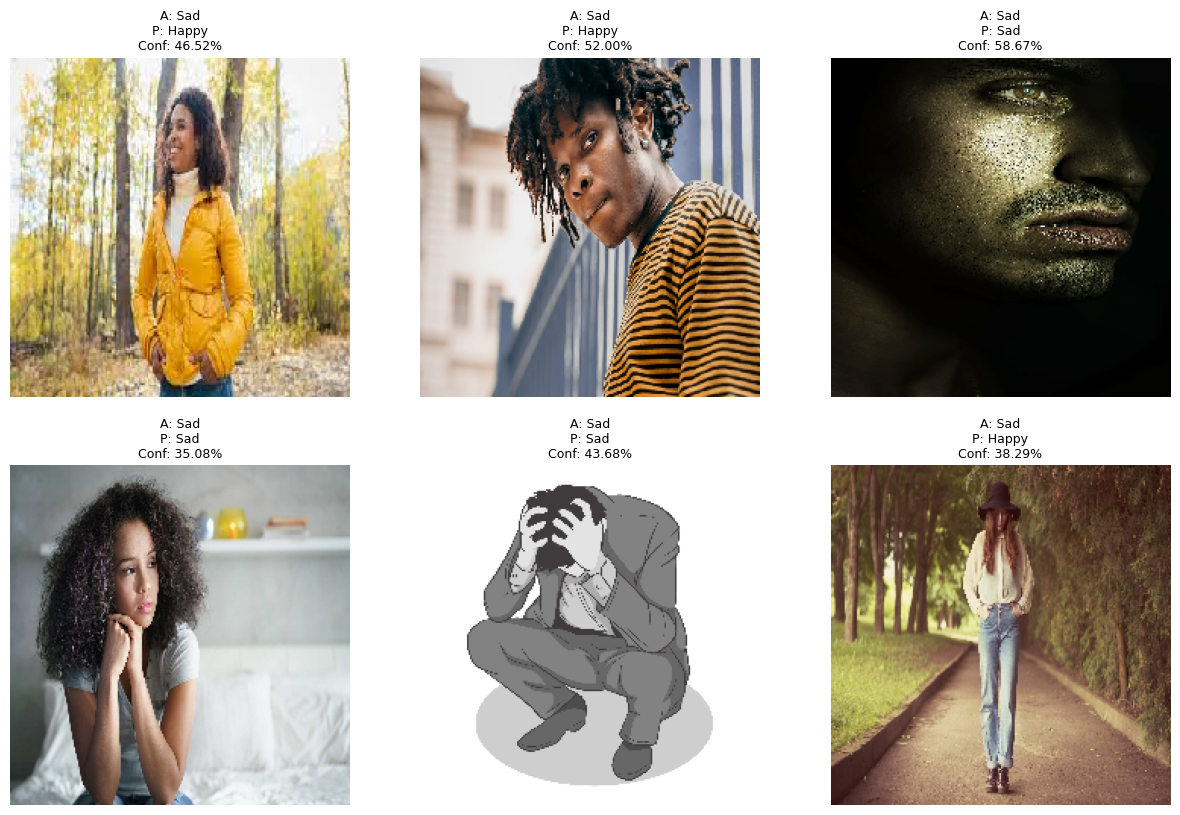

In [18]:
# Multiple Predictions Visualization (3×3 Grid

plt.figure(figsize=(15, 15))

for images, labels in val_generator:

    n = min(9, len(images))   # ✅ important

    for i in range(n):
        img = images[i]

        true_index = int(labels[i])
        true_label = class_names[true_index]

        preds = model.predict(np.expand_dims(img, axis=0), verbose=0)[0]
        pred_index = np.argmax(preds)
        pred_label = class_names[pred_index]
        confidence = preds[pred_index] * 100

        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.title(
            f"A: {true_label}\n"
            f"P: {pred_label}\n"
            f"Conf: {confidence:.2f}%",
            fontsize=9
        )
        plt.axis("off")

    break

plt.show()



In [19]:
# Save the Model

# model.save("emotion_vgg16_sparse_model.h5")
# print("✅ VGG16 emotion model saved successfully!")

In [20]:
# # Webcam

# import cv2
# import numpy as np
# import tensorflow as tf

# # ==========================
# # Load Haar Cascade
# # ==========================
# face_cascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")

# # ==========================
# # Load Trained VGG16 Model
# # ==========================
# IMG_SIZE = 224
# MODEL_PATH = "emotion_vgg16_sparse_model.h5"   # your VGG16 model

# model = tf.keras.models.load_model(MODEL_PATH)
# print("✅ VGG16 emotion model loaded")

# # ==========================
# # Class Names (MUST match training order!)
# # ==========================
# class_names = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

# # ==========================
# # Start Webcam
# # ==========================
# cap = cv2.VideoCapture(0)

# while True:
#     ret, frame = cap.read()
#     if not ret:
#         break

#     # --------------------
#     # Convert full frame to grayscale for face detection only
#     # --------------------
#     gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

#     # --------------------
#     # Detect faces on grayscale frame
#     # --------------------
#     faces = face_cascade.detectMultiScale(
#         gray,
#         scaleFactor=1.1,
#         minNeighbors=5,
#         minSize=(80, 80)
#     )

#     for (x, y, w, h) in faces:

#         # --------------------
#         # Crop face (COLOR, BGR)
#         # --------------------
#         face_color = frame[y:y+h, x:x+w]   # BGR crop

#         if face_color.size == 0:
#             continue

#         # --------------------
#         # Preprocess for VGG16 (rescale = 1./255 version)
#         # --------------------
#         # Resize
#         face = cv2.resize(face_color, (IMG_SIZE, IMG_SIZE))

#         # Convert BGR -> RGB
#         face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)   # (224, 224, 3)

#         # Normalize (SAME as training)
#         face_array = face.astype("float32") / 255.0

#         # Add batch dimension -> (1, 224, 224, 3)
#         face_array = np.expand_dims(face_array, axis=0)

#         # --------------------
#         # Predict Emotion
#         # --------------------
#         preds = model.predict(face_array, verbose=0)[0]

#         """
#         preds shape = (NUM_CLASSES,)
#         example -> [0.02, 0.01, 0.05, 0.78, 0.04, 0.06, 0.04]

#         pred_index = argmax(preds)
#         confidence = preds[pred_index] * 100
#         label = class_names[pred_index]
#         """

#         pred_index = np.argmax(preds)
#         confidence = preds[pred_index] * 100
#         label = class_names[pred_index]

#         text = f"{label} ({confidence:.2f}%)"

#         # --------------------
#         # Draw Results
#         # --------------------
#         cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

#         cv2.putText(
#             frame,
#             text,
#             (x, y - 10),
#             cv2.FONT_HERSHEY_SIMPLEX,
#             0.8,
#             (0, 255, 0),
#             2
#         )

#     # --------------------
#     # Show Frame
#     # --------------------
#     cv2.imshow("Emotion Detection (VGG16 RGB)", frame)

#     # Press ESC to exit
#     if cv2.waitKey(1) & 0xFF == 27:
#         break

# cap.release()
# cv2.destroyAllWindows()
